# Predictiong and Analysis of Inflation

Hi,

My name is Leon, and this is my Analysis of inflation project.

In the project below I am going to analyze relationship between different inflation metrics, as well as predict price inflation.  

In the older days, the definition of inflation was increase of monetary supply, which devalues the currency.  
However in modern days by inflation what is meant usually in increase in prices, which also means devaluation of the currency, but in a different way.  

For the monetary supply index I will use M1 for this notebook.  
For the price index I will use CPI index,

In the nootebook below I am going to analyze the relationship between M1 and CPI as well as those indices individually.  

The final goal of the notebook is to build a model to predict CPI inflation index by data including the M1.

## Data description

### Monetary supply

There are various indices for measuring how much money exists in the economy:  
M0, M1, M2, M3, M4  
Basically the difference between them is what is considered as money in the index and what is not,  
For example M0 index is used to measure the amount of all banknotes and coins, and M1 adds checkable deposits (a type of credit) on top of that.  
each subsequent index includes more asset classes on top of what the previous one includes.  
More information on the indices:  
https://www.wallstreetmojo.com/money-supply/

All the data is available on the [Federal Reserve website](https://fred.stlouisfed.org/).  
We'll use the following dataset as it is not adjusted to inflation:  
https://fred.stlouisfed.org/series/M1NS 

### Prices increases

For the data for increases in prices we'll choose CPI (Consumer Price Index),  
It is calculated by the [U.S. BUREAU OF LABOR STATISTICS](https://www.bls.gov/).  
In short, it measures the cost of various specific goods that are consumed by everyday people.
Although this index is far from perfect for many reasons,  
It is still the most common index of prices inflation.  
More information on the CPI and how it is measured:  
https://www.investopedia.com/terms/c/consumerpriceindex.asp   

The data can be downloaded from the BLS website:  
https://www.bls.gov/cpi/data.htm

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import datetime

# Model packages
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

# preprocessing libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.utils import resample
from numpy.random import RandomState
import warnings
from IPython.display import clear_output


# Evaluation
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score


# from keras.optimizers import RMSprop

from random import seed
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.ticker as mtick

## Loading datasets

The data is very small, as each dataset consists of just a single datapoint for every month for several decades.  
So all the data was already downloaded and saved locally to small excel files in this repository.

### CPI

Source: [BLS](https://data.bls.gov/PDQWeb/ap)

In [3]:
df_cpi_raw = pd.read_excel('cpi data.xlsx', skiprows=11)

In [4]:
df_cpi_raw.sample(3)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
104,2017.0,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524,244.076,246.163
53,1966.0,31.800,32.000,32.100,32.300,32.300,32.400,32.500,32.700,32.700,32.900,32.900,32.900,NaN,NaN
17,1930.0,17.100,17.000,16.900,17.000,16.900,16.800,16.600,16.500,16.600,16.500,16.400,16.100,NaN,NaN


### M1

In [5]:
df_m1_raw = pd.read_excel('M1NS.xls', skiprows=10)

In [6]:
df_m1_raw.sample(3)

,observation_date,M1NS
414,1993-07-01,1083.1
165,1972-10-01,244.2
19,1960-08-01,139.4


### M2

In [7]:
df_m2_raw = pd.read_excel('M2NS.xls', skiprows=10)

In [8]:
df_m2_raw.sample(3)

,observation_date,M2NS
750,2021-07-01,20571.9
21,1960-10-01,309.9
296,1983-09-01,2081.1


Looks like M1 and M2 data dataset are already stored in convenient Time Series format,  
But We'll need to transform the CPI data to match the other datasets.

## Checking Data integrity

### CPI

In [9]:
df_cpi_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    110 non-null    float64
 1   Jan     110 non-null    float64
 2   Feb     110 non-null    float64
 3   Mar     110 non-null    float64
 4   Apr     110 non-null    float64
 5   May     110 non-null    float64
 6   Jun     110 non-null    float64
 7   Jul     110 non-null    float64
 8   Aug     110 non-null    float64
 9   Sep     109 non-null    float64
 10  Oct     109 non-null    float64
 11  Nov     109 non-null    float64
 12  Dec     109 non-null    float64
 13  HALF1   39 non-null     float64
 14  HALF2   38 non-null     float64
dtypes: float64(15)
memory usage: 13.0 KB


In [10]:
df_cpi_raw.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
0,1913.0,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,NaN,NaN
1,1914.0,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,NaN,NaN
2,1915.0,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,NaN,NaN
3,1916.0,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,NaN,NaN
4,1917.0,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,NaN,NaN


We see 2 definetely excess columns here: HALF1, HALF2.  
Better get rid of them now.

In [11]:
df_cpi_raw = df_cpi_raw.drop(["HALF1", "HALF2"], axis=1)

### M1

In [12]:
df_m1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  764 non-null    datetime64[ns]
 1   M1NS              764 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 KB


In [13]:
df_m1_raw.head(10)

,observation_date,M1NS
0,1959-01-01,142.2
1,1959-02-01,139.3
2,1959-03-01,138.4
3,1959-04-01,139.7
4,1959-05-01,138.7
5,1959-06-01,139.4
6,1959-07-01,140.3
7,1959-08-01,140.0
8,1959-09-01,140.3
9,1959-10-01,140.7


In [14]:
df_m1_raw.shape

(764, 2)

The data here is already in the format I want to be, so there won't be much of data transformation on this dataframe.

In [15]:
df_m1_raw = df_m1_raw.rename(columns={
    'observation_date' : 'month',
    'M1NS' : 'M1'})

In [16]:
df_m2_raw.sample(3)

,observation_date,M2NS
484,1999-05-01,4464.1
59,1963-12-01,396.4
737,2020-06-01,18103.7


In [17]:
df_m2_raw = df_m2_raw.rename(columns={
    'observation_date' : 'month',
    'M2NS' : 'M2'})

## Preprocessing

In [18]:
df_inflation = df_m1_raw.copy()

In [19]:
df_inflation

,month,M1
0,1959-01-01,142.2
1,1959-02-01,139.3
2,1959-03-01,138.4
3,1959-04-01,139.7
4,1959-05-01,138.7
...,...,...
759,2022-04-01,20817.8
760,2022-05-01,20537.9
761,2022-06-01,20535.4
762,2022-07-01,20471.7


In [20]:
df_cpi_raw = df_cpi_raw.melt(id_vars=["Year"]).sort_values(by="Year")

In [21]:
df_cpi_raw.head(15)

,Year,variable,value
0,1913.0,Jan,9.8
330,1913.0,Apr,9.8
550,1913.0,Jun,9.8
660,1913.0,Jul,9.9
220,1913.0,Mar,9.8
770,1913.0,Aug,9.9
1210,1913.0,Dec,10.0
880,1913.0,Sep,10.0
110,1913.0,Feb,9.8
990,1913.0,Oct,10.0


I'll just rename month to a normal feature name,
I call it **month_raw** as I want to use month afterwards for the full month format

In [22]:
df_cpi_raw = df_cpi_raw.rename(columns={
    'variable' : 'month_raw',
    'value' : 'CPI'})

In [23]:
df_cpi_raw.head(15)

,Year,month_raw,CPI
0,1913.0,Jan,9.8
330,1913.0,Apr,9.8
550,1913.0,Jun,9.8
660,1913.0,Jul,9.9
220,1913.0,Mar,9.8
770,1913.0,Aug,9.9
1210,1913.0,Dec,10.0
880,1913.0,Sep,10.0
110,1913.0,Feb,9.8
990,1913.0,Oct,10.0


In [24]:
df_cpi_raw['Year'] = df_cpi_raw['Year'].astype('int')

In [25]:
df_cpi_raw['month'] = pd.to_datetime(df_cpi_raw['month_raw'] + ' ' + df_cpi_raw['Year'].astype('str'))

In [26]:
df_cpi_raw = df_cpi_raw.sort_values(by='month')

In [27]:
df_inflation = df_inflation.merge(df_cpi_raw, on="month", how="outer")

In [28]:
df_inflation = df_inflation.merge(df_m2_raw, on="month", how="outer")

In [29]:
df_inflation

,month,M1,Year,month_raw,CPI,M2
0,1959-01-01,142.2,1959,Jan,29.0,289.8
1,1959-02-01,139.3,1959,Feb,28.9,287.7
2,1959-03-01,138.4,1959,Mar,28.9,287.9
3,1959-04-01,139.7,1959,Apr,29.0,290.2
4,1959-05-01,138.7,1959,May,29.0,290.2
...,...,...,...,...,...,...
1315,1958-12-01,NaN,1958,Dec,28.9,NaN
1316,2022-09-01,NaN,2022,Sep,NaN,NaN
1317,2022-10-01,NaN,2022,Oct,NaN,NaN
1318,2022-11-01,NaN,2022,Nov,NaN,NaN


In [30]:
df_inflation = df_inflation.sort_values(by='month').reset_index(drop=True)

In [31]:
# period_name = 'monthly'
# period_length = 1

In [32]:
def add_pct_change_and_sma_per_timeframe_to_df(period_name, period_length):
    df_inflation['cpi_' + period_name + '_change'] = df_inflation['CPI'].pct_change(periods=period_length)
    df_inflation['m1_' + period_name + '_change'] = df_inflation['M1'].pct_change(period_length)
    df_inflation['m2_' + period_name + '_change'] = df_inflation['M2'].pct_change(period_length)
    df_inflation['cpi_' + period_name + '_sma'] = df_inflation['cpi_' + period_name + '_change'].dropna().rolling(15).mean()
    df_inflation['m1_' + period_name + '_sma'] = df_inflation['m1_' + period_name + '_change'].dropna().rolling(15).mean()
    df_inflation['m2_' + period_name + '_sma'] = df_inflation['m2_' + period_name + '_change'].dropna().rolling(15).mean()

In [33]:
add_pct_change_and_sma_per_timeframe_to_df('monthly', 1)

In [34]:
add_pct_change_and_sma_per_timeframe_to_df('quarterly', 3)

In [35]:
add_pct_change_and_sma_per_timeframe_to_df('half_year', 6)

In [36]:
add_pct_change_and_sma_per_timeframe_to_df('yearly', 12)

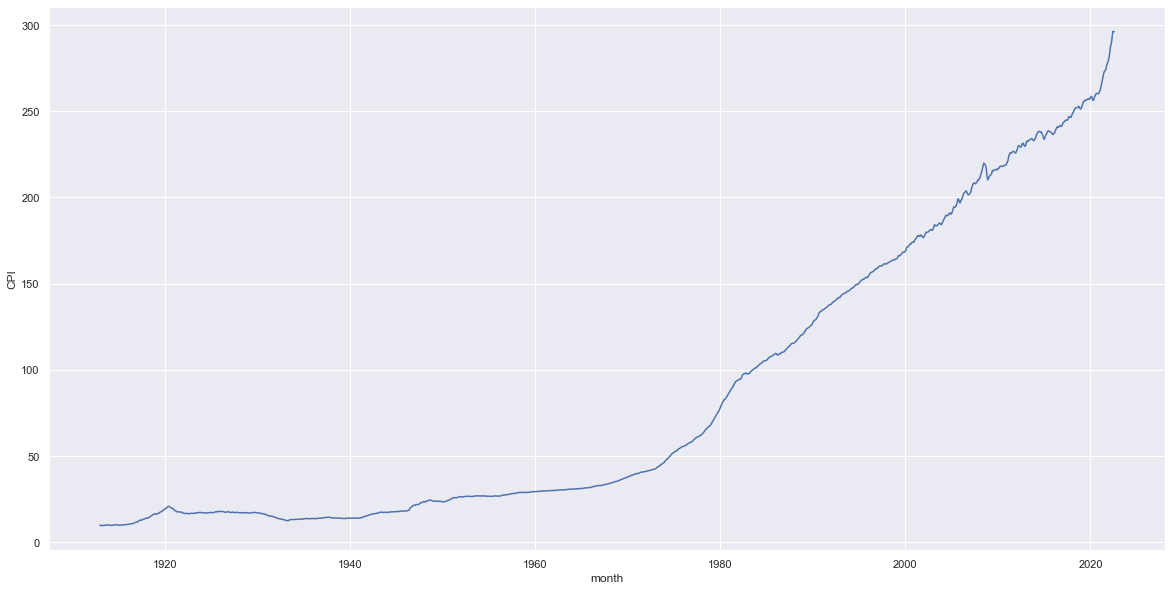

In [57]:
sns.lineplot(data=df_inflation, x="month", y="CPI")
plt.show()

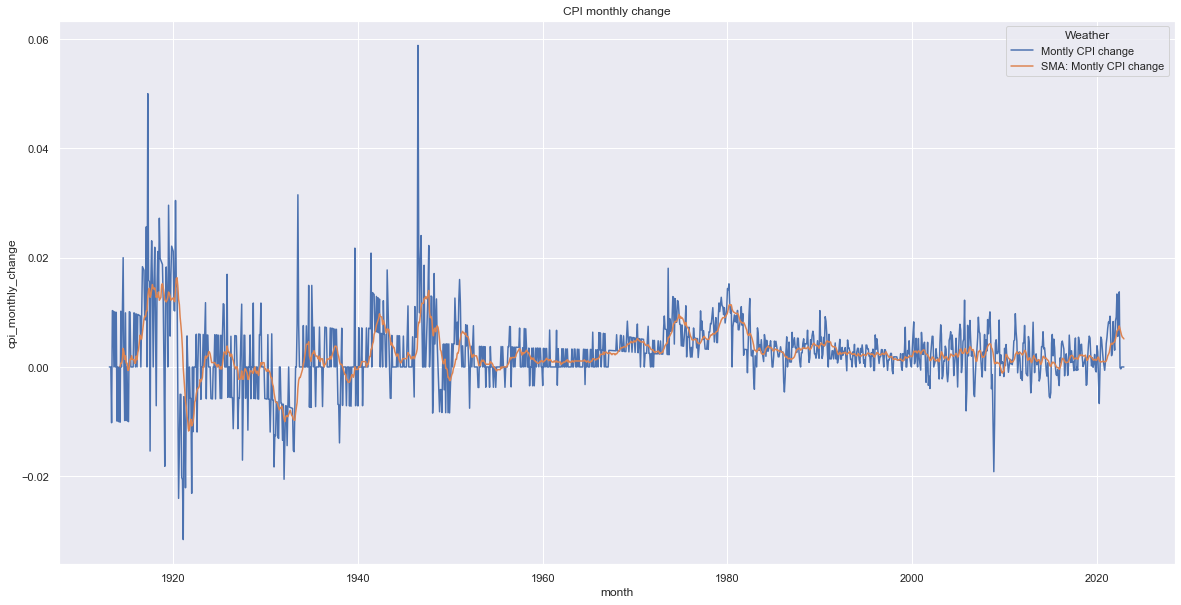

In [51]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, axes = plt.subplots(1, 1)
ax=axes
sns.lineplot(data=df_inflation, x="month", y="cpi_monthly_change", ax=ax, legend='auto')
sns.lineplot(data=df_inflation, x="month", y="cpi_monthly_sma", ax=ax, legend='auto')
ax.set(title="CPI monthly change")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(labels=["Montly CPI change","SMA: Montly CPI change"], title = "Weather")
plt.show()

The data looks very noisy amd it looks like the seasonality is way different in the 60th than in the last 3 decades.  
Also there are many differences in monetary concepts between now and then.  
I think it would be wiser to look at a shorter timeframe, say let's take a look at the data starting from 1996, so it's approximately 2.5 decades before today

In [52]:
df_inflation_last_decades = df_inflation.query('month > "Jan 1994"')

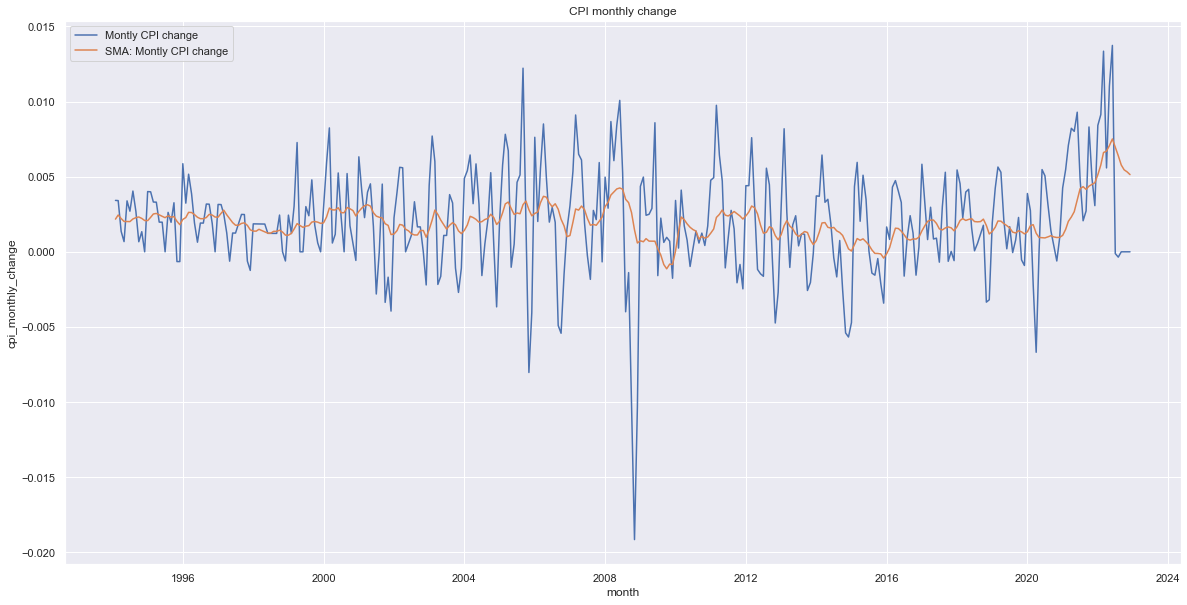

In [80]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, axes = plt.subplots(1, 1)
ax=axes
sns.lineplot(data=df_inflation_last_decades, x="month", y="cpi_monthly_change", ax=ax, legend='auto')
sns.lineplot(data=df_inflation_last_decades, x="month", y="cpi_monthly_sma", ax=ax, legend='auto')
ax.set(title="CPI monthly change")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(labels=["Montly CPI change","SMA: Montly CPI change"])
plt.show()

## EDA

### CPI

In [83]:
def plot_pct_changes_of_inflation(df, period_name, metric):
    sns.set(rc = {'figure.figsize':(20,6)})
    fig, axes = plt.subplots(1, 1)
    ax=axes
    sns.lineplot(data=df, x="month", y=metric + "_" + period_name + "_change", ax=ax, legend='auto')
    sns.lineplot(data=df, x="month", y=metric + "_" + period_name + "_sma", ax=ax, legend='auto')
    ax.set(title=metric.upper() + " " + period_name + " change")
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend(labels=[period_name.capitalize() + " " + metric.upper() +
                       " change","SMA: " + period_name.capitalize() + " " + metric.upper() +" change"])
    plt.show()

In [87]:
list_periods = ['monthly', 
                'quarterly', 
                'half_year', 
                'yearly']

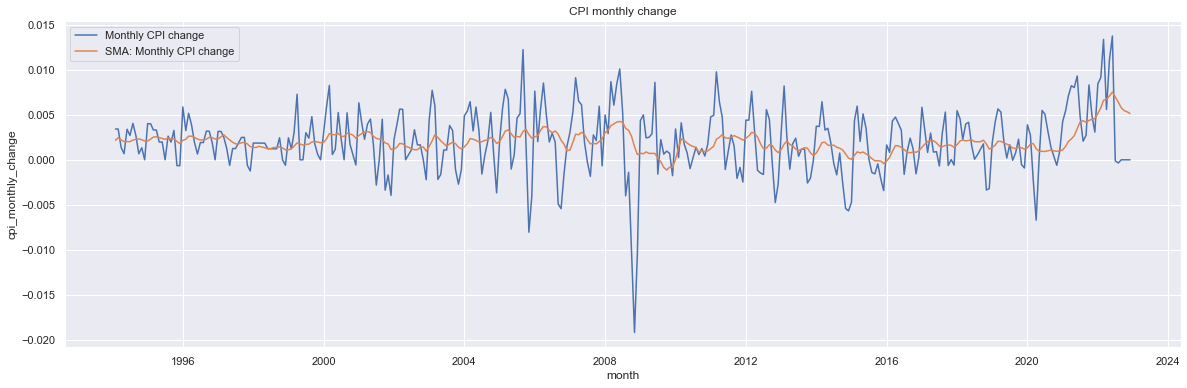

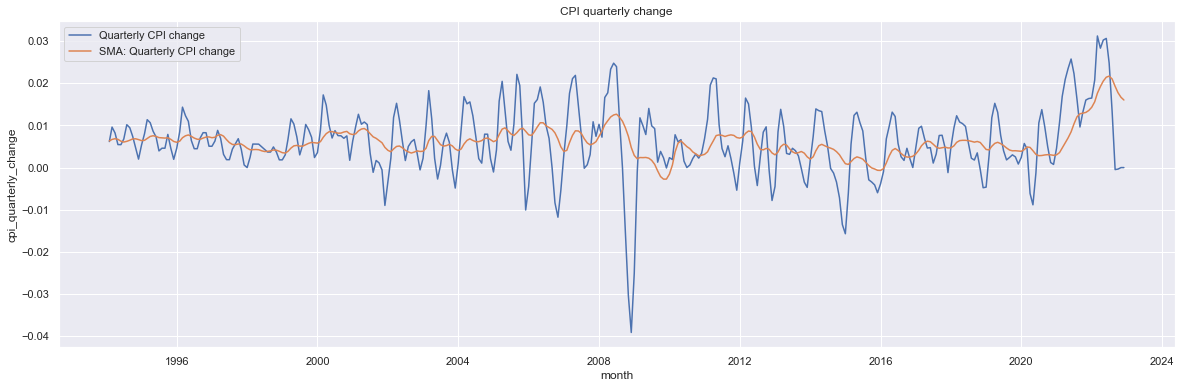

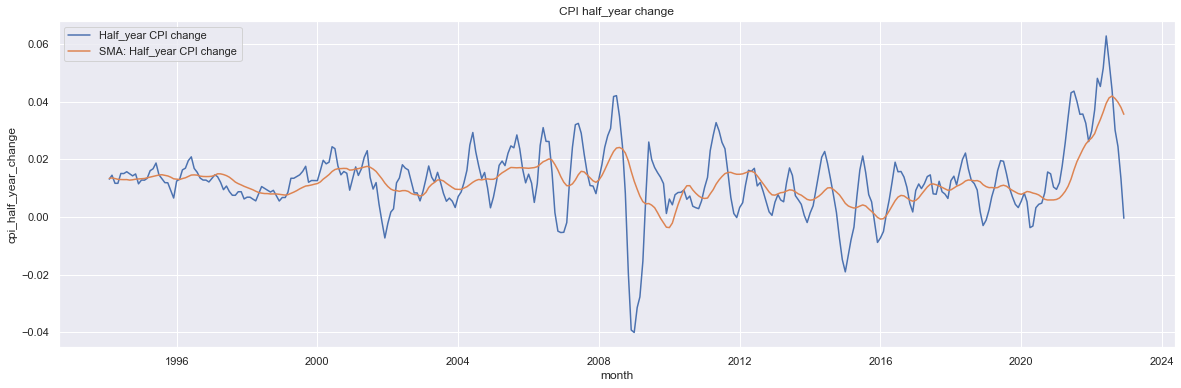

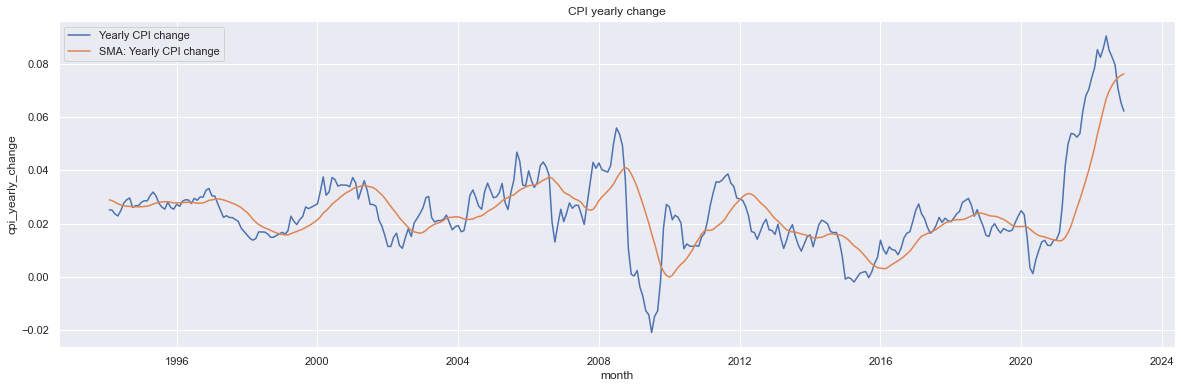

In [88]:
for p in list_periods:
    plot_pct_changes_of_inflation(df_inflation_last_decades, p, 'cpi')

### M1

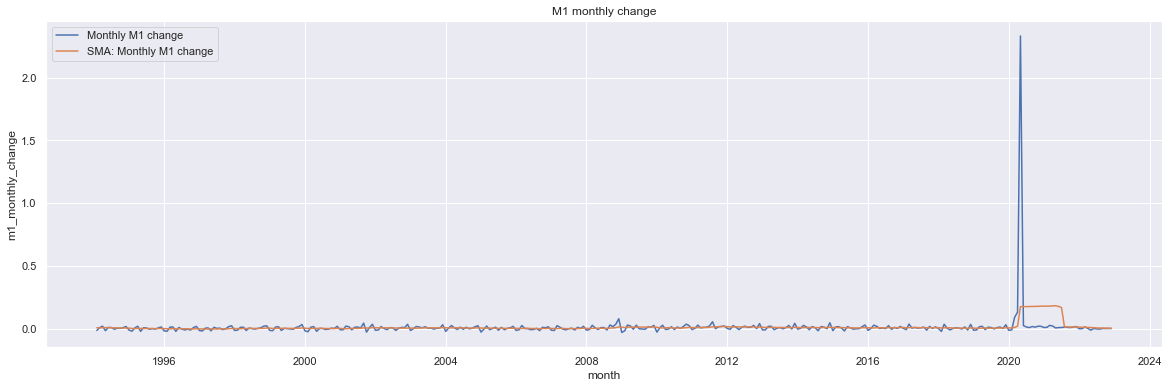

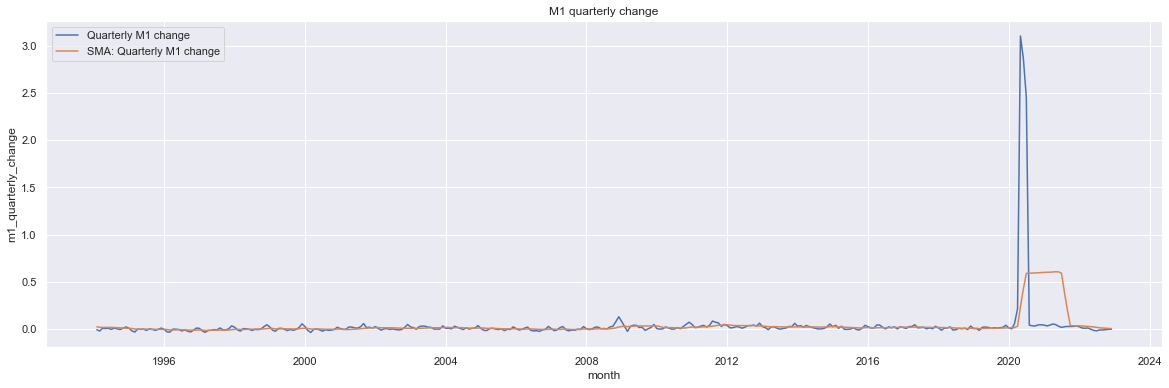

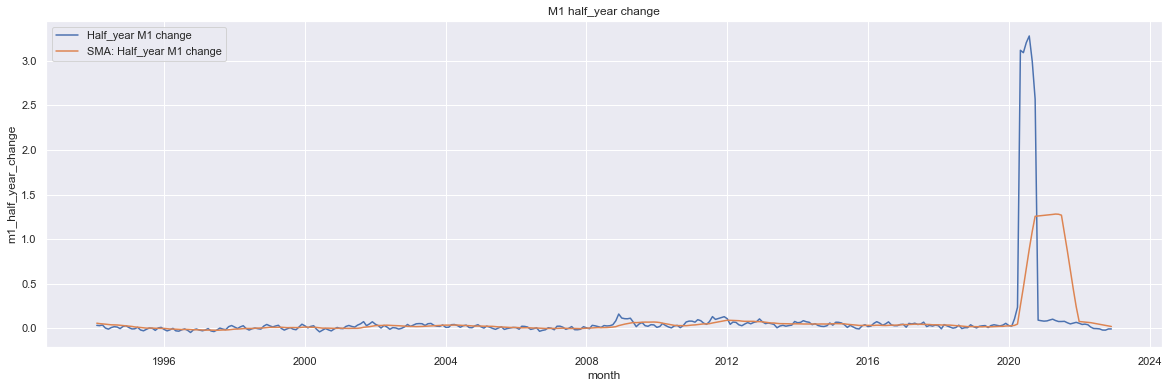

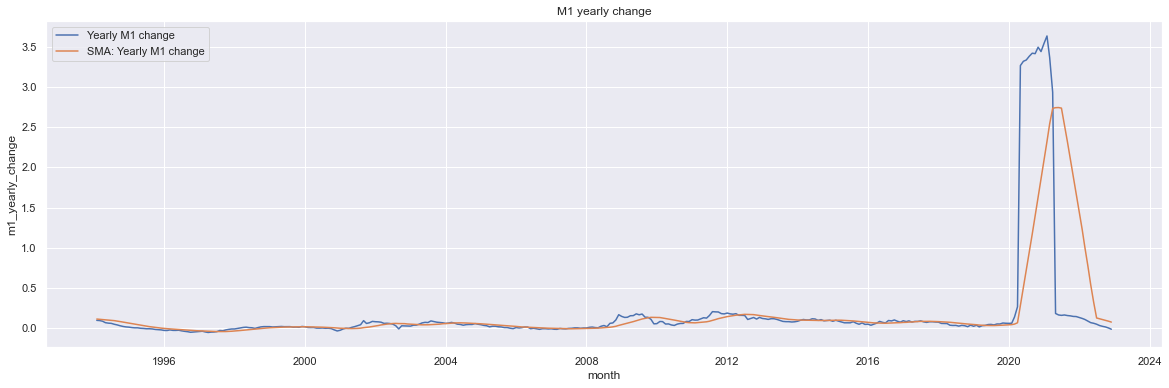

In [90]:
for p in list_periods:
    plot_pct_changes_of_inflation(df_inflation_last_decades, p, 'm1')

### M2

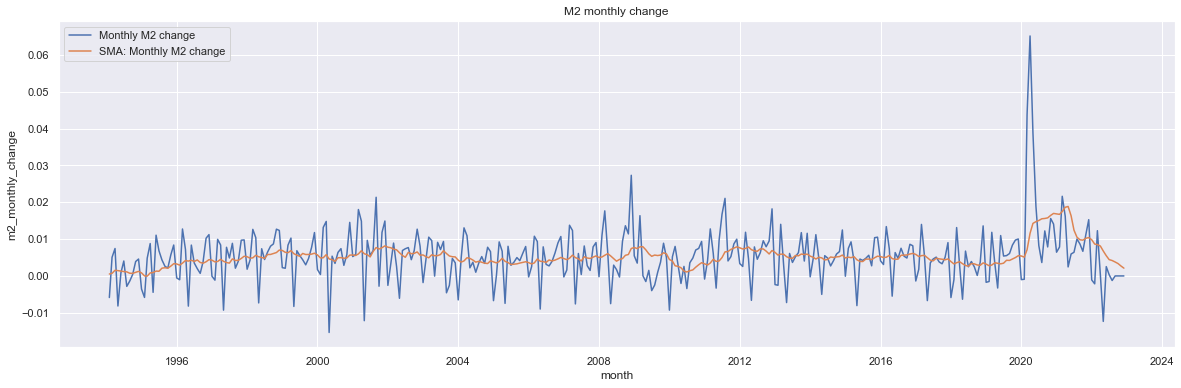

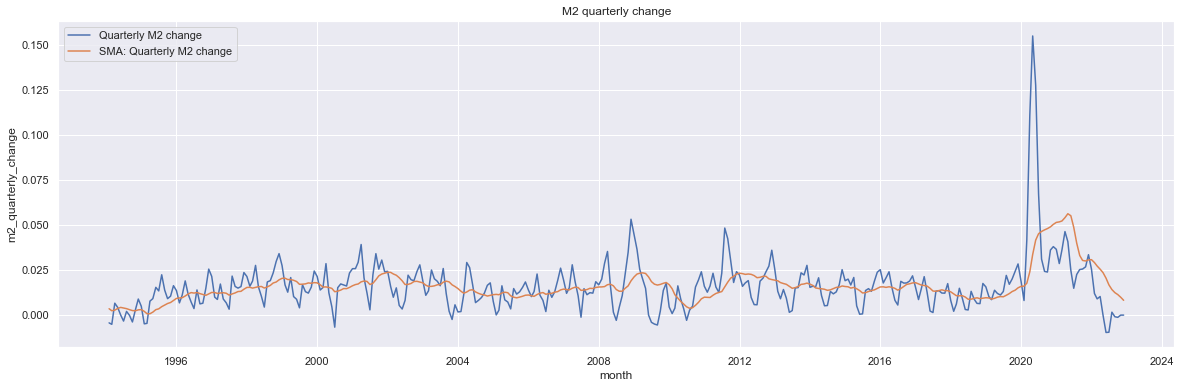

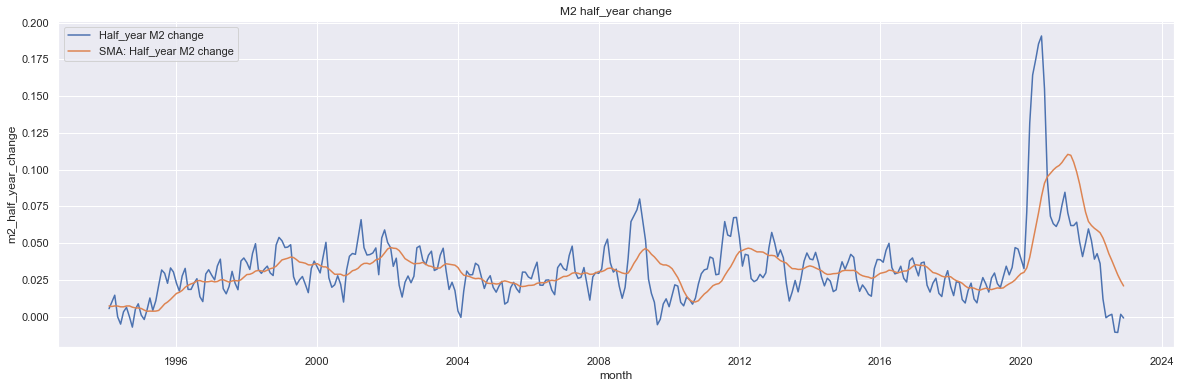

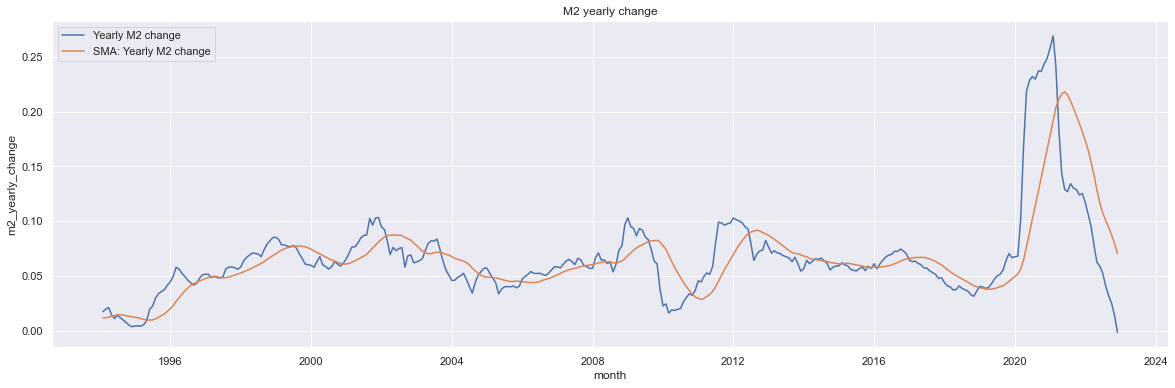

In [89]:
for p in list_periods:
    plot_pct_changes_of_inflation(df_inflation_last_decades, p, 'm2')

### Distribution

Now after we looked at the change as a line plot, lets also see the distributions of inflation change

In [ ]:
df_inflation

In [ ]:
sns.distplot(df_inflation['cpi_monthy_change'])

In [ ]:
sns.distplot(df_inflation['cpi_yearly_change'])

In [ ]:
df_inflation['cpi_yearly_change'].describe()

In [ ]:
(1+df_inflation['cpi_yearly_change'].mean())**20

In [ ]:
df_inflation

In [ ]:
months_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [ ]:
df_temp = df_inflation.groupby('month_raw').agg({"cpi_monthy_change" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
sns.barplot(data=df_temp, x='month_raw', y='cpi_monthy_change')

In [ ]:
df_temp = df_inflation.groupby('month_raw').agg({"m1_monthy_change" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
sns.barplot(data=df_temp, x='month_raw', y='m1_monthy_change')

In [ ]:
df_temp

### relationship between the measures

In [ ]:
df_inflation_time_filtered = df_inflation.query('month >= "Jan 1994" and month <= "Jan 2012"')

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = plt.subplot()
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_change")
sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_sma")
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="m1_yearly_change")
sns.lineplot(data=df_inflation_time_filtered.shift(0), x="month", y="m1_yearly_sma")
ax.set(title="M1 yearly change")
plt.show()

In [ ]:
df_inflation_time_filtered['m1_yearly_sma_shift'] = df_inflation_time_filtered['m1_yearly_sma'].shift(24)*0.25

In [ ]:
df_inflation_time_filtered['m1_yearly_change_shift'] = df_inflation_time_filtered['m1_yearly_change'].shift(24) * 0.2

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = plt.subplot()
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_change")
sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_sma")
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="m1_yearly_change")
sns.lineplot(data=df_inflation_time_filtered.shift(0).reset_index(), x="month", y="m1_yearly_sma_shift")
ax.set(title="M1 yearly change")
plt.show()

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = plt.subplot()
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_change")
sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_change")
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="m1_yearly_change")
sns.lineplot(data=df_inflation_time_filtered.shift(0).reset_index(), x="month", y="m1_yearly_change_shift")
ax.set(title="M1 yearly change")
plt.show()

We see graphically that the CPI change correlates heavily with the M1 change 2 years delayed

In [ ]:
df_inflation_time_filtered.corr()['cpi_yearly_sma']['m1_yearly_sma_shift']

In [ ]:
df_inflation_time_filtered

In [ ]:
df_inflation_time_filtered.corr()['cpi_yearly_change']['m1_yearly_sma_shift']

While linearry the correlation is weaker than expected, graphically we see heavy correlation

## Feature engineering

First let's decide what our target is.  
As the rule of thumb the CPI only increases and not necessary lineary, as well as usually after a large spike it doesn't bounce back to where it was, it would be difficult to predict the CPI itself.  
However, we can predict how much it would increase.

so our target will be the next cpi_yearly_change

In [ ]:
df_inflation['target'] = df_inflation['cpi_monthy_change'].shift(-1)

In [ ]:
df_inflation = df_inflation.dropna()

In [ ]:
df_inflation['month_num'] = df_inflation['month'].dt.month

In [ ]:
df_inflation = df_inflation.set_index('month')

In [ ]:
df_inflation = df_inflation.drop(['Year', 'month_raw'], axis=1)

In [ ]:
df_inflation

In [ ]:
df_inflation = df_inflation[:-10]

In [ ]:
df_inflation

### Logorithmic transformation
As some features are growing exponentially (e.g. CPI, M1),  
it would be wiser to apply a log function to the feature, as linear models work less well with exponential data

In [ ]:
df_inflation['M1'] = np.log(df_inflation['M1'])
df_inflation['M2'] = np.log(df_inflation['M2'])
df_inflation['CPI'] = np.log(df_inflation['CPI'])

In [ ]:
df_inflation

## Train-test split

In [ ]:
df_train = df_inflation[:-60]

In [ ]:
df_test = df_inflation[-60:]

In [ ]:
X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

In [ ]:
y_train = df_train['target']
y_test = df_test['target']

## Model Training

### Baseline

In [ ]:
model_linreg = LinearRegression()

In [ ]:
model_linreg.fit(X_train, y_train)

In [ ]:
model_linreg.score(X_test, y_test)

In [ ]:
y_pred_linreg = model_linreg.predict(X_test)

In [ ]:
y_pred_linreg

In [ ]:
y_test

In [ ]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred_linreg)

In [ ]:
#sns.lineplot(y_test)
sns.lineplot(y_pred_linreg)

### CatBoost

In [ ]:
model_catboost = CatBoostRegressor()

In [ ]:
model_catboost.fit(X_train, y_train)

In [ ]:
model_catboost.score(X_test, y_test)

In [ ]:
y_pred_catboost = model_catboost.predict(X_test)

In [ ]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred_catboost)